In [ ]:
#Random Forest trained with non-linear data, with data augmentation SAME for each label and using labels-v4
#Trained without new features: Objective function size

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import os
import time

In [2]:
# nombre de instancia
# número restricciones
# número variables
# si es lineal o no (true / false)
# porcentaje de restricciones unarias, binarias, porcentaje de ternarias, porcentaje cuaternarias o más 
# porcentaje de terminos unarios, binarios, porcentaje de ternarios, porcentaje cuaternarios o más 
# porcentaje de terminos positivos/negativos en restricciones
# porcentaje de terminos positivos/negativos en funcion obj
# timestep
# solver (label)

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path=main_path+"datasets-v4/"
feat_path=d_path+"features/"

columns = ["# contraints","# variables","linearity","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% degree 1 terms","% degree 2 terms","% degree 3 terms","% degree 4+ terms","% positive in constr","% positive in obj func","timestep","solver"]
names=[]
num_rest=[]
num_var=[]
linear=[]
r_unary=[]
r_binary=[]
r_ternary=[]
r_cuaternary=[]
t_unary=[]
t_binary=[]
t_ternary=[]
t_cuaternary=[]
#t_fo=[]
t_pos_r=[]
t_pos_fo=[]
timestep=[]
solvers=[]

#Recolectar data de txt files
with open(d_path+"txt_files/data_ordered.txt") as f:
    lines = f.readlines()
    for l in lines:
        words=l.split()
        name=words[0][words[0].find("/")+1:]
        print(name)
        with open(feat_path+name) as feat_f:
            l=feat_f.readlines()
            w=l[0].split()
            for n in range(500): #repetir 500 cada instancia, para que cuadre con los timesteps
                names.append(w[0])
                num_rest.append(int(w[1]))
                num_var.append(int(w[2]))
                linear.append(int(w[3]))
                r_unary.append(float(w[4]))
                r_binary.append(float(w[5]))
                r_ternary.append(float(w[6]))
                r_cuaternary.append(float(w[7]))
                t_unary.append(float(w[8]))
                t_binary.append(float(w[9]))
                t_ternary.append(float(w[10]))
                t_cuaternary.append(float(w[11]))
                #t_fo.append(float(w[12]))
                t_pos_r.append(float(w[13]))
                t_pos_fo.append(float(w[14]))
                timestep.append(n)
        
with open(main_path+"labels-v4.txt") as f:
    lines = f.readlines()
    for l in lines:
        for word in l.split():
            solvers.append(int(word))

Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-2-irabcde.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-2-irEDCBA.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-1-irabcde.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-1-irEDCBA.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-2-irabcde.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-2-irEDCBA.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-irabcde.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-irEDCBA.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-abcdeir.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-combined-EDCBAir.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-combined-irabcde.opb
Benchmark1/normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-combined-irEDCBA.opb
Benchmark1/normalized-single-ob

Benchmark10/normalized-single-obj-f46-DC_Side1.seq-A-2-1-irabcde.opb
Benchmark10/normalized-single-obj-f46-DC_Side1.seq-A-2-1-irEDCBA.opb
Benchmark10/normalized-single-obj-f46-DC_Side1.seq-B-2-1-irabcde.opb
Benchmark10/normalized-single-obj-f47-DC_Side1.seq-B-2-combined-irabcde.opb
Benchmark10/normalized-single-obj-f47-DC_Side1.seq-B-2-combined-irEDCBA.opb
Benchmark10/normalized-single-obj-f46-DC_Side1.seq-A-2-combined-irEDCBA.opb
Benchmark10/normalized-single-obj-f46-DC_Side1.seq-A-2-combined-irabcde.opb
Benchmark11/normalized-single-obj-f49-DC_TotalLoss.seq-A-2-2-irEDCBA.opb
Benchmark11/normalized-single-obj-f48-DC_TotalLoss.seq-B-2-2-irabcde.opb
Benchmark11/normalized-single-obj-f48-DC_TotalLoss.seq-B-2-2-irEDCBA.opb
Benchmark11/normalized-single-obj-f48-DC_TotalLoss.seq-A-2-2-irabcde.opb
Benchmark11/normalized-single-obj-f48-DC_TotalLoss.seq-B-2-1-irabcde.opb
Benchmark11/normalized-single-obj-f49-DC_TotalLoss.seq-B-2-1-irEDCBA.opb
Benchmark11/normalized-single-obj-f49-DC_TotalLoss.

Benchmark17/normalized-autocorr_bern50-50.lin.opb
Benchmark17/normalized-autocorr_bern55-41.lin.opb
Benchmark17/normalized-autocorr_bern55-55.lin.opb
Benchmark17/normalized-autocorr_bern60-45.lin.opb
Benchmark17/normalized-autocorr_bern60-60.lin.opb
Benchmark18/normalized-cardqp_inlp.lin.opb
Benchmark19/normalized-crossdock_15x8.lin.opb
Benchmark20/normalized-faclay60.lin.opb
Benchmark20/normalized-faclay70.lin.opb
Benchmark20/normalized-faclay75.lin.opb
Benchmark20/normalized-faclay80.lin.opb
Benchmark21/normalized-graphpart_2g-0044-1601.lin.opb
Benchmark21/normalized-graphpart_2g-0055-0062.lin.opb
Benchmark21/normalized-graphpart_2g-0066-0066.lin.opb
Benchmark21/normalized-graphpart_2g-0077-0077.lin.opb
Benchmark21/normalized-graphpart_2g-0088-0088.lin.opb
Benchmark21/normalized-graphpart_2g-0099-9211.lin.opb
Benchmark21/normalized-graphpart_2g-1010-0824.lin.opb
Benchmark22/normalized-graphpart_3g-0234-0234.lin.opb
Benchmark22/normalized-graphpart_3g-0333-0333.lin.opb
Benchmark22/nor

Benchmark43/normalized-edgecross10-070.lin.opb
Benchmark43/normalized-edgecross14-058.lin.opb
Benchmark43/normalized-edgecross20-040.lin.opb
Benchmark43/normalized-edgecross14-176.lin.opb
Benchmark43/normalized-edgecross22-048.lin.opb
Benchmark43/normalized-edgecross14-098.lin.opb
Benchmark43/normalized-edgecross14-117.lin.opb
Benchmark43/normalized-edgecross24-057.lin.opb
Benchmark43/normalized-edgecross20-080.lin.opb
Benchmark43/normalized-edgecross14-137.lin.opb
Benchmark43/normalized-edgecross22-096.lin.opb
Benchmark43/normalized-edgecross24-115.lin.opb
Benchmark44/normalized-faclay20h.lin.opb
Benchmark44/normalized-faclay25.lin.opb
Benchmark44/normalized-faclay30h.lin.opb
Benchmark44/normalized-faclay30.lin.opb
Benchmark44/normalized-faclay33.lin.opb
Benchmark44/normalized-faclay35.lin.opb
Benchmark45/normalized-graphpart_2pm-0044-0044.lin.opb
Benchmark45/normalized-graphpart_2pm-0055-0055.lin.opb
Benchmark45/normalized-graphpart_2pm-0066-0066.lin.opb
Benchmark45/normalized-graphp

Benchmark61/normalized-sporttournament46.opb
Benchmark61/normalized-sporttournament48.opb
Benchmark61/normalized-sporttournament50.opb
Benchmark62/normalized-ped2.G.recomb5-0.01-5.opb
Benchmark62/normalized-ped2.G.recomb10-0.01-5.opb
Benchmark62/normalized-ped2.G.recomb5-0.01-1.opb
Benchmark62/normalized-ped2.G.recomb10-0.01-2.opb
Benchmark62/normalized-ped2.G.recomb1-0.01-2.opb
Benchmark62/normalized-ped2.G.recomb10-0.01-4.opb
Benchmark62/normalized-ped2.G.recomb5-0.01-2.opb
Benchmark62/normalized-ped2.G.recomb5-0.10-7.opb
Benchmark62/normalized-ped2.G.recomb5-0.10-10.opb
Benchmark62/normalized-ped2.G.recomb5-0.10-9.opb
Benchmark62/normalized-ped2.G.recomb10-0.10-10.opb
Benchmark62/normalized-ped2.G.recomb5-0.10-8.opb
Benchmark62/normalized-ped2.G.recomb10-0.10-7.opb
Benchmark62/normalized-ped2.G.recomb1-0.10-8.opb
Benchmark62/normalized-ped2.G.recomb1-0.20-13.opb
Benchmark62/normalized-ped2.G.recomb10-0.20-11.opb
Benchmark62/normalized-ped2.G.recomb10-0.20-14.opb
Benchmark62/normaliz

Benchmark95/normalized-minisat25_6_3_7_ic.opb
Benchmark95/normalized-minisat25_6_3_6_ic.opb
Benchmark95/normalized-minisat25_6_3_5_ic.opb
Benchmark95/normalized-minisat25_6_3_4_ic.opb
Benchmark95/normalized-minisat25_6_3_3_ic.opb
Benchmark95/normalized-minisat25_6_3_2_ic.opb
Benchmark95/normalized-minisat25_6_3_1_ic.opb
Benchmark95/normalized-minisat25_6_3_0_ic.opb
Benchmark96/normalized-minisat50_6_9_9_ic.opb
Benchmark96/normalized-minisat50_6_9_8_ic.opb
Benchmark96/normalized-minisat50_6_9_7_ic.opb
Benchmark96/normalized-minisat50_6_9_6_ic.opb
Benchmark96/normalized-minisat50_6_9_5_ic.opb
Benchmark96/normalized-minisat50_6_9_4_ic.opb
Benchmark96/normalized-minisat50_6_9_3_ic.opb
Benchmark96/normalized-minisat50_6_9_2_ic.opb
Benchmark96/normalized-minisat50_6_9_1_ic.opb
Benchmark96/normalized-minisat50_6_9_0_ic.opb
Benchmark97/normalized-minisat100_16_6_5_ic.opb
Benchmark97/normalized-minisat100_16_6_2_ic.opb
Benchmark97/normalized-minisat100_16_6_4_ic.opb
Benchmark97/normalized-minis

Benchmark120/normalized-NG.dot_luby_20null0mast_rapportOE2.0_TMAX300_K192_cod2.opb
Benchmark120/normalized-NG.dot_luby_20null50mast_rapportOE1.0_TMAX15_K192_cod2.opb
Benchmark121/normalized-NG.dot_luby_50null50mast_rapportOE2.0_TMAX120_K192_cod2.opb
Benchmark121/normalized-NG.dot_luby_50null50mast_rapportOE1.0_TMAX300_K192_cod2.opb
Benchmark121/normalized-NG.dot_luby_50null50mast_rapportOE1.0_TMAX180_K192_cod2.opb
Benchmark121/normalized-NG.dot_luby_50null20mast_rapportOE2.0_TMAX60_K192_cod2.opb
Benchmark121/normalized-NG.dot_luby_50null0mast_rapportOE1.0_TMAX15_K192_cod2.opb
Benchmark122/normalized-NG.dot_unif_0null10mast_rapportOE1.0_TMAX60_K192_cod2.opb
Benchmark123/normalized-NG.dot_unif_10null20mast_rapportOE2.0_TMAX60_K192_cod2.opb
Benchmark123/normalized-NG.dot_unif_10null20mast_rapportOE1.0_TMAX300_K192_cod2.opb
Benchmark123/normalized-NG.dot_unif_10null0mast_rapportOE2.0_TMAX15_K192_cod2.opb
Benchmark124/normalized-NG.dot_unif_20null20mast_rapportOE2.0_TMAX300_K192_cod2.opb
Be

Benchmark175/normalized-sonata.cudf.trendy.opb
Benchmark175/normalized-xvfb.cudf.trendy.opb
Benchmark175/normalized-monodevelop-nunit.cudf.trendy.opb
Benchmark176/normalized-1097.cudf.trendy.opb
Benchmark176/normalized-658.cudf.trendy.opb
Benchmark176/normalized-1098.cudf.trendy.opb
Benchmark176/normalized-1093.cudf.trendy.opb
Benchmark176/normalized-902.cudf.trendy.opb
Benchmark176/normalized-121.cudf.trendy.opb
Benchmark176/normalized-557.cudf.trendy.opb
Benchmark176/normalized-1335.cudf.trendy.opb
Benchmark177/normalized-randaefc7c.cudf.trendy.opb
Benchmark177/normalized-rand65d021.cudf.trendy.opb
Benchmark177/normalized-rand0c02bc.cudf.trendy.opb
Benchmark177/normalized-randfe95e3.cudf.trendy.opb
Benchmark177/normalized-rand2d8467.cudf.trendy.opb
Benchmark177/normalized-randb87834.cudf.trendy.opb
Benchmark177/normalized-randf7d077.cudf.trendy.opb
Benchmark177/normalized-randa491d5.cudf.trendy.opb
Benchmark177/normalized-randd1cab2.cudf.trendy.opb
Benchmark177/normalized-rand6d579e.

Benchmark186/normalized-j9023_3.std.opb
Benchmark186/normalized-j9025_10.std.opb
Benchmark186/normalized-j9022_8.std.opb
Benchmark186/normalized-j9024_9.std.opb
Benchmark186/normalized-j9017_9.std.opb
Benchmark186/normalized-j9027_5.std.opb
Benchmark186/normalized-j9031_6.std.opb
Benchmark186/normalized-j9043_5.std.opb
Benchmark186/normalized-j9045_2.std.opb
Benchmark186/normalized-j9039_4.std.opb
Benchmark186/normalized-j9038_7.std.opb
Benchmark186/normalized-j9043_10.std.opb
Benchmark186/normalized-j9044_5.std.opb
Benchmark186/normalized-j9041_1.std.opb
Benchmark186/normalized-j9033_3.std.opb
Benchmark186/normalized-j9038_2.std.opb
Benchmark186/normalized-j9036_4.std.opb
Benchmark187/normalized-j12016_10.std.opb
Benchmark187/normalized-j1207_6.std.opb
Benchmark187/normalized-j12016_2.std.opb
Benchmark187/normalized-j12017_7.std.opb
Benchmark187/normalized-j12020_8.std.opb
Benchmark187/normalized-j12019_2.std.opb
Benchmark187/normalized-j1205_7.std.opb
Benchmark187/normalized-j12019_5

Benchmark197/normalized-50-750-false-45-90-4-4000opt.opb
Benchmark197/normalized-50-750-false-45-90-4-3000opt.opb
Benchmark197/normalized-50-750-false-45-90-4-1000opt.opb
Benchmark197/normalized-50-750-false-45-90-4-5000opt.opb
Benchmark198/normalized-fx30.opb
Benchmark198/normalized-fx49.opb
Benchmark198/normalized-fx57.opb
Benchmark198/normalized-fx60.opb
Benchmark198/normalized-fx63.opb
Benchmark198/normalized-fx75.opb
Benchmark198/normalized-fx84.opb
Benchmark198/normalized-fx92.opb
Benchmark198/normalized-fx97.opb
Benchmark199/normalized-fir05_trarea_ac.opb
Benchmark199/normalized-fir03_trarea_ac.opb
Benchmark199/normalized-fir04_trarea_ac.opb
Benchmark199/normalized-fir07_trarea_ac.opb
Benchmark199/normalized-fir09_trarea_ac.opb
Benchmark199/normalized-fir06_trarea_ac.opb
Benchmark199/normalized-fir08_trarea_ac.opb
Benchmark199/normalized-fir10_trarea_ac.opb
Benchmark200/normalized-reduced-fir05_trarea_ac.opb
Benchmark200/normalized-reduced-fir03_trarea_ac.opb
Benchmark200/normal

Benchmark217/normalized-mds_200_10_1.opb
Benchmark218/normalized-mds_500_60_5.opb
Benchmark218/normalized-mds_500_60_4.opb
Benchmark218/normalized-mds_500_10_1.opb
Benchmark218/normalized-mds_500_60_2.opb
Benchmark218/normalized-mds_500_60_1.opb
Benchmark218/normalized-mds_500_25_5.opb
Benchmark218/normalized-mds_500_25_4.opb
Benchmark218/normalized-mds_500_25_3.opb
Benchmark218/normalized-mds_500_25_2.opb
Benchmark218/normalized-mds_500_25_1.opb
Benchmark218/normalized-mds_500_10_5.opb
Benchmark218/normalized-mds_500_10_4.opb
Benchmark218/normalized-mds_500_10_3.opb
Benchmark218/normalized-mds_500_10_2.opb
Benchmark218/normalized-mds_500_60_3.opb
Benchmark219/normalized-mds_1000_60_5.opb
Benchmark219/normalized-mds_1000_60_4.opb
Benchmark219/normalized-mds_1000_60_3.opb
Benchmark219/normalized-mds_1000_60_2.opb
Benchmark219/normalized-mds_1000_60_1.opb
Benchmark219/normalized-mds_1000_25_5.opb
Benchmark219/normalized-mds_1000_25_4.opb
Benchmark219/normalized-mds_1000_25_3.opb
Benchmar

Benchmark227/factor-mod-size=6-P0=5-P1=59-P2=47-P3=43-P4=7-P5=19-P6=67-P7=41-B.opb
Benchmark227/factor-mod-size=6-P0=67-P1=47-P2=2-P3=53-P4=23-P5=7-P6=41-P7=31-B.opb
Benchmark227/factor-mod-size=6-P0=47-P1=23-P2=47-P3=53-P4=59-P5=23-P6=37-P7=61-B.opb
Benchmark227/factor-mod-size=6-P0=11-P1=2-P2=41-P3=47-P4=37-P5=17-P6=41-P7=43-P8=59-B.opb
Benchmark227/factor-mod-size=6-P0=41-P1=53-P2=67-P3=59-P4=53-P5=61-P6=29-P7=29-P8=17-B.opb
Benchmark227/factor-mod-size=6-P0=29-P1=2-P2=59-P3=2-P4=47-P5=53-P6=37-P7=53-P8=53-B.opb
Benchmark227/factor-mod-size=6-P0=53-P1=53-P2=41-P3=41-P4=41-P5=53-P6=41-P7=47-P8=17-B.opb
Benchmark227/factor-mod-size=6-P0=23-P1=11-P2=13-P3=17-P4=19-P5=53-P6=67-P7=29-P8=7-B.opb
Benchmark227/factor-mod-size=6-P0=5-P1=53-P2=23-P3=7-P4=31-P5=59-P6=59-P7=37-P8=41-P9=67-B.opb
Benchmark227/factor-mod-size=6-P0=11-P1=37-P2=59-P3=23-P4=53-P5=31-P6=59-P7=29-P8=2-P9=67-B.opb
Benchmark227/factor-mod-size=6-P0=47-P1=43-P2=59-P3=29-P4=31-P5=13-P6=59-P7=53-P8=67-P9=17-B.opb
Benchmark2

Benchmark230/factor-mod-size=9-P0=149-P1=191-P2=199-B.opb
Benchmark230/factor-mod-size=9-P0=137-P1=127-P2=347-B.opb
Benchmark230/factor-mod-size=9-P0=457-P1=137-P2=191-B.opb
Benchmark230/factor-mod-size=9-P0=263-P1=409-P2=29-P3=379-B.opb
Benchmark230/factor-mod-size=9-P0=499-P1=293-P2=223-P3=277-B.opb
Benchmark230/factor-mod-size=9-P0=19-P1=337-P2=467-P3=53-B.opb
Benchmark230/factor-mod-size=9-P0=149-P1=419-P2=307-P3=223-B.opb
Benchmark230/factor-mod-size=9-P0=487-P1=163-P2=173-P3=211-B.opb
Benchmark230/factor-mod-size=9-P0=347-P1=137-P2=419-P3=449-P4=47-B.opb
Benchmark230/factor-mod-size=9-P0=251-P1=139-P2=89-P3=173-P4=107-B.opb
Benchmark230/factor-mod-size=9-P0=449-P1=149-P2=137-P3=137-P4=83-B.opb
Benchmark230/factor-mod-size=9-P0=127-P1=293-P2=269-P3=7-P4=157-B.opb
Benchmark230/factor-mod-size=9-P0=43-P1=101-P2=251-P3=307-P4=499-B.opb
Benchmark230/factor-mod-size=9-P0=397-P1=307-P2=37-P3=127-P4=401-P5=331-B.opb
Benchmark230/factor-mod-size=9-P0=373-P1=127-P2=409-P3=11-P4=263-P5=269-

Benchmark234/normalized-mps-v2-20-10-momentum3.opb
Benchmark234/normalized-mps-v2-20-10-van.opb
Benchmark234/normalized-mps-v2-20-10-sp97ar.opb
Benchmark234/normalized-mps-v2-20-10-mod011.opb
Benchmark234/normalized-mps-v2-20-10-stp3d.opb
Benchmark234/normalized-mps-v2-20-10-dano3mip.opb
Benchmark234/normalized-mps-v2-20-10-ds.opb
Benchmark235/normalized-mps-v2-20-10-bal8x12.opb
Benchmark236/normalized-mps-v2-20-10-bk4x3.opb
Benchmark237/normalized-mps-v2-20-10-gr4x6.opb
Benchmark238/normalized-mps-v2-20-10-n370e.opb
Benchmark238/normalized-mps-v2-20-10-n370c.opb
Benchmark238/normalized-mps-v2-20-10-n370b.opb
Benchmark238/normalized-mps-v2-20-10-n370a.opb
Benchmark238/normalized-mps-v2-20-10-n3709.opb
Benchmark238/normalized-mps-v2-20-10-n3708.opb
Benchmark238/normalized-mps-v2-20-10-n3707.opb
Benchmark238/normalized-mps-v2-20-10-n3706.opb
Benchmark238/normalized-mps-v2-20-10-n3705.opb
Benchmark238/normalized-mps-v2-20-10-n3704.opb
Benchmark238/normalized-mps-v2-20-10-n3703.opb
Benchma

Benchmark285/normalized-factor-sizeN=240-sizeP=121-sizeQ=240-817963885.opb
Benchmark285/normalized-factor-sizeN=240-sizeP=121-sizeQ=240-817963885-max.opb
Benchmark285/normalized-factor-sizeN=240-sizeP=121-sizeQ=240-330229238.opb
Benchmark286/normalized-factor-sizeN=260-sizeP=131-sizeQ=260-581480794.opb
Benchmark286/normalized-factor-sizeN=260-sizeP=131-sizeQ=260-581480794-max.opb
Benchmark286/normalized-factor-sizeN=260-sizeP=131-sizeQ=260-466115074.opb
Benchmark286/normalized-factor-sizeN=260-sizeP=131-sizeQ=260-466115074-max.opb
Benchmark287/normalized-factor-sizeN=280-sizeP=141-sizeQ=280-999529433.opb
Benchmark287/normalized-factor-sizeN=280-sizeP=141-sizeQ=280-999529433-max.opb
Benchmark287/normalized-factor-sizeN=280-sizeP=141-sizeQ=280-254810631.opb
Benchmark287/normalized-factor-sizeN=280-sizeP=141-sizeQ=280-254810631-max.opb
Benchmark288/normalized-factor-sizeN=300-sizeP=151-sizeQ=300-692949159.opb
Benchmark288/normalized-factor-sizeN=300-sizeP=151-sizeQ=300-692949159-max.opb
B

Benchmark326/normalized-reduced-mps-v2-20-10-etamacro.opb
Benchmark326/normalized-reduced-mps-v2-20-10-tuff.opb
Benchmark326/normalized-reduced-mps-v2-20-10-grow15.opb
Benchmark326/normalized-reduced-mps-v2-20-10-scsd1.opb
Benchmark326/normalized-reduced-mps-v2-20-10-fffff800.opb
Benchmark326/normalized-reduced-mps-v2-20-10-grow22.opb
Benchmark326/normalized-reduced-mps-v2-20-10-pilot4.opb
Benchmark326/normalized-reduced-mps-v2-20-10-scfxm2.opb
Benchmark326/normalized-reduced-mps-v2-20-10-gfrd-pnc.opb
Benchmark326/normalized-reduced-mps-v2-20-10-standata.opb
Benchmark326/normalized-reduced-mps-v2-20-10-standgub.opb
Benchmark326/normalized-reduced-mps-v2-20-10-perold.opb
Benchmark326/normalized-reduced-mps-v2-20-10-scsd6.opb
Benchmark326/normalized-reduced-mps-v2-20-10-sierra.opb
Benchmark326/normalized-reduced-mps-v2-20-10-scfxm3.opb
Benchmark326/normalized-reduced-mps-v2-20-10-maros.opb
Benchmark326/normalized-reduced-mps-v2-20-10-ship04s.opb
Benchmark326/normalized-reduced-mps-v2-20-

Benchmark337/normalized-reduced-mps-v2-20-10-nsrand_ipx.opb
Benchmark337/normalized-reduced-mps-v2-20-10-blp-ir98.opb
Benchmark337/normalized-reduced-mps-v2-20-10-UMTS.opb
Benchmark337/normalized-reduced-mps-v2-20-10-berlin_5_8_0.opb
Benchmark337/normalized-reduced-mps-v2-20-10-sp98ic.opb
Benchmark337/normalized-reduced-mps-v2-20-10-roll3000.opb
Benchmark337/normalized-reduced-mps-v2-20-10-blp-ic97.opb
Benchmark337/normalized-reduced-mps-v2-20-10-sp97ic.opb
Benchmark337/normalized-reduced-mps-v2-20-10-core2586-950.opb
Benchmark337/normalized-reduced-mps-v2-20-10-sp97ar.opb
Benchmark337/normalized-reduced-mps-v2-20-10-blp-ic98.opb
Benchmark337/normalized-reduced-mps-v2-20-10-sp98ar.opb
Benchmark337/normalized-reduced-mps-v2-20-10-bg512142.opb
Benchmark337/normalized-reduced-mps-v2-20-10-core2536-691.opb
Benchmark337/normalized-reduced-mps-v2-20-10-blp-ar98.opb
Benchmark337/normalized-reduced-mps-v2-20-10-tr12-30.opb
Benchmark337/normalized-reduced-mps-v2-20-10-railway_8_1_0.opb
Benchmar

Benchmark350/normalized-s3-3-3-5pb.opb
Benchmark350/normalized-s3-3-3-3pb.opb
Benchmark350/normalized-s3-3-3-2pb.opb
Benchmark351/normalized-s4-4-3-8pb.opb
Benchmark351/normalized-s4-4-3-6pb.opb
Benchmark351/normalized-s4-4-3-2pb.opb
Benchmark351/normalized-s4-4-3-3pb.opb
Benchmark351/normalized-s4-4-3-1pb.opb
Benchmark351/normalized-s4-4-3-7pb.opb
Benchmark351/normalized-s4-4-3-4pb.opb
Benchmark351/normalized-s4-4-3-5pb.opb
Benchmark351/normalized-s4-4-3-9pb.opb
Benchmark351/normalized-s4-4-3-10pb.opb
Benchmark352/normalized-C17.opb
Benchmark352/normalized-b1.opb
Benchmark352/normalized-cm42a.opb
Benchmark352/normalized-cc.opb
Benchmark352/normalized-mux.opb
Benchmark352/normalized-c8.opb
Benchmark352/normalized-cmb.opb
Benchmark352/normalized-my_adder.opb
Benchmark352/normalized-9symml.opb
Benchmark352/normalized-C432.opb
Benchmark353/normalized-circ4_3.opb
Benchmark353/normalized-circ6_3.opb
Benchmark353/normalized-circ8_3.opb
Benchmark353/normalized-circ10_3.opb
Benchmark354/normal

Benchmark370/normalized-opt-market-split_5_40_3.opb
Benchmark370/normalized-opt-market-split_5_40_4.opb
Benchmark370/normalized-opt-market-split_5_40_1.opb
Benchmark371/normalized-opt-market-split_6_50_3.opb
Benchmark371/normalized-opt-market-split_6_50_4.opb
Benchmark371/normalized-opt-market-split_6_50_1.opb
Benchmark371/normalized-opt-market-split_6_50_2.opb
Benchmark372/normalized-opt-market-split_7_60_4.opb
Benchmark372/normalized-opt-market-split_7_60_3.opb
Benchmark372/normalized-opt-market-split_7_60_1.opb
Benchmark372/normalized-opt-market-split_7_60_2.opb
Benchmark373/normalized-opt-market-split_8_70_3.opb
Benchmark373/normalized-opt-market-split_8_70_4.opb
Benchmark373/normalized-opt-market-split_8_70_1.opb
Benchmark373/normalized-opt-market-split_8_70_2.opb
Benchmark374/normalized-factor-size=9-P=167-Q=347.opb
Benchmark374/normalized-factor-size=9-P=307-Q=317.opb
Benchmark374/normalized-factor-size=9-P=97-Q=479.opb
Benchmark374/normalized-factor-size=9-P=97-Q=457.opb
Benchm

Benchmark374/normalized-factor-size=9-P=191-Q=389.opb
Benchmark374/normalized-factor-size=9-P=191-Q=449.opb
Benchmark374/normalized-factor-size=9-P=191-Q=509.opb
Benchmark374/normalized-factor-size=9-P=197-Q=479.opb
Benchmark374/normalized-factor-size=9-P=211-Q=347.opb
Benchmark374/normalized-factor-size=9-P=223-Q=263.opb
Benchmark374/normalized-factor-size=9-P=223-Q=307.opb
Benchmark374/normalized-factor-size=9-P=223-Q=347.opb
Benchmark374/normalized-factor-size=9-P=223-Q=383.opb
Benchmark374/normalized-factor-size=9-P=223-Q=421.opb
Benchmark374/normalized-factor-size=9-P=223-Q=431.opb
Benchmark374/normalized-factor-size=9-P=227-Q=383.opb
Benchmark374/normalized-factor-size=9-P=229-Q=239.opb
Benchmark374/normalized-factor-size=9-P=229-Q=307.opb
Benchmark374/normalized-factor-size=9-P=23-Q=293.opb
Benchmark374/normalized-factor-size=9-P=23-Q=379.opb
Benchmark374/normalized-factor-size=9-P=233-Q=347.opb
Benchmark374/normalized-factor-size=9-P=239-Q=373.opb
Benchmark374/normalized-factor

In [3]:
#Crear dataframe
# dataframe with no names, so that it doesn't convert everything to str 
data=np.array([num_rest,num_var,linear,r_unary,r_binary,r_ternary,r_cuaternary,t_unary,t_binary,t_ternary,t_cuaternary,t_pos_r,t_pos_fo,timestep,solvers])
df = pd.DataFrame(data.T, columns=columns)

#print(df.head())

In [4]:
x=df[["# contraints","# variables","linearity","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% degree 1 terms","% degree 2 terms","% degree 3 terms","% degree 4+ terms","% positive in constr","% positive in obj func","timestep"]]
y=df[['solver']]

#agrupar diferentes timestpes de cada instancia en un mismo set
random.seed(9) #same seed to generate same random numbers as other models
train_indx=[]
inst_train=[]
test_indx=[]
for i in range(0,3128): # v4
    r = random.randint(0,2)
    if(r==2):
        for j in range(0,500):
            test_indx.append(500*i+j)
    else:
        inst_train.append(i)
        for j in range(0,500):
            train_indx.append(500*i+j)

x_train=x.iloc[train_indx]
x_test=x.iloc[test_indx]
y_train=y.iloc[train_indx]
y_test=y.iloc[test_indx]
y_train_og=y.iloc[train_indx]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1027000, 14)
(537000, 14)
(1027000, 1)
(537000, 1)


In [5]:
#Data augmentation para training set de instancias con clases distintas a gurobi (5)

indx_dis=[] #indexes of instances with disadvantaged labels 

#identificar instancias que tengan clase distinta a gurobi
for i in inst_train:
    has_dis=False
    for j in range(500):
        ind=500*i+j
        if(solvers[ind]!=5):
            has_dis=True
            break
    if(has_dis):
        for j in range(500):
            indx_dis.append(500*i+j)

print(len(indx_dis))
print(len(train_indx), end="\n\n")            

#agregar las instancias al final de x_train e y_train
x_train_dis=x.iloc[indx_dis]
y_train_dis=y.iloc[indx_dis]

x_train=x_train.append(x_train_dis)
y_train=y_train.append(y_train_dis)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

674500
1027000

(1701500, 14)
(537000, 14)
(1701500, 1)
(537000, 1)


In [6]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="sqrt", criterion="gini",random_state=3)
rf_model.fit(np.nan_to_num(x_train.astype(np.float32)), y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [7]:
y_pred = rf_model.predict(np.nan_to_num(x_test.astype(np.float32)))

In [8]:
print("Accuracy",metrics.accuracy_score(y_test.values.ravel(), y_pred))
pred = rf_model.predict_proba(np.nan_to_num(x_test.astype(np.float32)))
print("Loss",metrics.log_loss(y_test.values.ravel(), pred))

Accuracy 0.7098603351955307
Loss 4.621847962569092


In [9]:
#Save
l=int(len(y_test)/500)
y_test_np=y_test.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_test.txt", "w")
np.savetxt(f,y_test_np.reshape(y_test_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_pred)/500)
y_pred_np=y_pred.reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_preds.txt", "w")
np.savetxt(f,y_pred_np.reshape(y_pred_np.shape[0],-1),fmt='%s')
f.close()

#print(y_train_np.shape)
#print(y_pred_np)

In [10]:
l=int(len(y_train)/500)
y_train_np=y_train.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_train.txt", "w")
np.savetxt(f,y_train_np.reshape(y_train_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_train_og)/500)
y_train_og_np=y_train_og.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_train_og.txt", "w")
np.savetxt(f,y_train_og_np.reshape(y_train_og_np.shape[0], -1),fmt="%s")
f.close()

In [11]:
#Feature importances
importances = rf_model.feature_importances_
feats = x.columns

f=open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/features_and_acc.txt", "w")

i=0
while i < len(feats):
    print("Importance of feature "+feats[i]+" is "+str(importances[i]))
    f.write("Importance of feature "+feats[i]+" is "+str(importances[i]))
    i = i+1

print(metrics.accuracy_score(y_test.values.ravel(), y_pred))
f.write("Testing accuracy: "+str(metrics.accuracy_score(y_test.values.ravel(), y_pred)))

f.close()

Importance of feature # contraints is 0.1282076497331236
Importance of feature # variables is 0.10311169312847512
Importance of feature linearity is 0.010536499089243668
Importance of feature % 1 term constr is 0.05536469637668509
Importance of feature % 2 terms constr is 0.07178017545110976
Importance of feature % 3 terms constr is 0.07204859005928134
Importance of feature % 4+ terms constr is 0.08908509793883512
Importance of feature % degree 1 terms is 0.11998025823287989
Importance of feature % degree 2 terms is 0.03354664825501986
Importance of feature % degree 3 terms is 0.0012843523787858507
Importance of feature % degree 4+ terms is 0.0016183224233150262
Importance of feature % positive in constr is 0.1060129877088372
Importance of feature % positive in obj func is 0.05514836532374171
Importance of feature timestep is 0.15227466390066677
0.7098603351955307


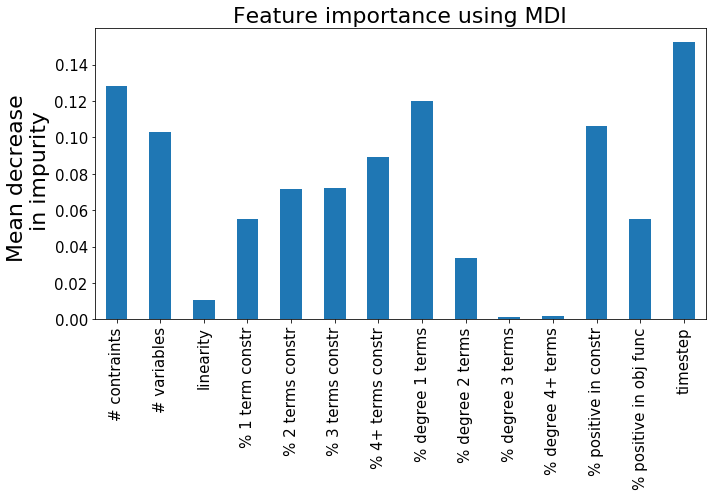

In [13]:
#Grafico feature importances
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feats)

fsize = 22

fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax, figsize = (10,7), fontsize=fsize-7)
forest_importances.plot.bar(ax=ax, figsize = (10,7), fontsize=fsize-7)
plt.xticks(rotation=90, fontsize=fsize-7)
ax.set_title("Feature importance using MDI", fontsize=fsize)
ax.set_ylabel("Mean decrease \n in impurity", fontsize=fsize)
fig.tight_layout()

#print(importances)

https://data36.com/random-forest-in-python/


# Prediction Time

In [14]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

l=int(len(y_pred)/500)
t_preds=np.empty(l*500)
i=0

#prediccion
for idx in test_indx:
    #crear dataframe de solo esa instancia-timestep
    x_i = x.iloc[[idx]]
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = rf_model.predict(np.nan_to_num(x_i.astype(np.float32)))
    tiempo=time.time()-start
    t_preds[i]=tiempo
    
    i=i+1

In [15]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_randomForest_nonlinear-v4-no_obj_func_size.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.02369356 0.0182972  0.01643324 ... 0.00870848 0.0086267  0.00857043]
